In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import itertools
import random as random
import shutil

colors_ls = (list(mcolors.TABLEAU_COLORS)[:120])
colors_ls_cyc = itertools.cycle(list(mcolors.TABLEAU_COLORS)[:120])
markers_ls = ['o','s','v', '+', 'o', '*']
markers = itertools.cycle(markers_ls)

from scipy.special import psi
from scipy.special import polygamma
from scipy.special import erf, erfinv
from scipy.optimize import curve_fit

%matplotlib inline
mpl.style.use('classic')
mpl.style.use(['seaborn-whitegrid'])
from matplotlib.ticker import ScalarFormatter, NullFormatter
mpl.rcParams['figure.dpi'] = 400
mpl.rcParams.update({'font.size': 16})

current_dir = os.getcwd() 
kPSep = os.sep

import struct
FLOAT_SIZE = 8

In [3]:
Lx = 20
Ly = 1
Ns = Lx * Ly
d = 1
bc = 1

Jdd = -1.0

cos_theta_af = np.array([1 if i % 2 == 0 else -1 for i in range(Lx)])
cos_theta_f = np.ones(Lx)

en_ferro = Jdd * np.sum(cos_theta_f[0:-1] * cos_theta_f[1:])
en_aferro = Jdd * np.sum(cos_theta_af[0:-1] * cos_theta_af[1:])

en_ferro, en_aferro

(-19.0, 19.0)

In [4]:
step = 0.1
J_max = 2.0
J_min = -2.0



J_s = np.arange(J_min, J_max+step, step).astype(np.float16)
J_d = np.arange()
J_s, len(J_s)

TypeError: arange() requires stop to be specified.

In [96]:
df = pd.read_csv(f"classical/type=square,_BC={bc},dim={d},Ns={Lx*Ly},Lx={Lx},Ly={Ly},Lz=1.dat", sep = '\t', names = ['J1','J2','E_ferro', 'E_aferro','E_ed','E_aed', 'idx']).dropna(axis = 1)
df['E_aferro'] -= en_aferro
df['E_ferro'] -= en_ferro
df['difference'] = df['E_aferro'] - df['E_ferro']
df[['E_ferro','E_aferro','E_ed','E_aed','difference']] /= Ns
print(df.dtypes)
df

J1            float64
J2            float64
E_ferro       float64
E_aferro      float64
E_ed          float64
E_aed         float64
difference    float64
dtype: object


,J1,J2,E_ferro,E_aferro,E_ed,E_aed,difference
0,1.6,-2.0,-1.177247,-2.871982,0.0,0.0,-1.694735
1,1.6,-1.9,-1.188245,-3.039470,0.0,0.0,-1.851225
2,1.6,-1.8,-1.112953,-2.973006,0.0,0.0,-1.860053
3,1.6,-1.7,-1.194347,-2.876834,0.0,0.0,-1.682487
4,1.6,-1.6,-1.156274,-2.278514,0.0,0.0,-1.122240
...,...,...,...,...,...,...,...
856,-2.0,1.6,-2.824636,-1.454919,0.0,0.0,1.369717
857,-2.0,1.7,-0.912637,-1.224571,0.0,0.0,-0.311934
858,-2.0,1.8,-2.980966,-1.234475,0.0,0.0,1.746491
859,-2.0,1.9,-2.441164,-1.645691,0.0,0.0,0.795473


In [97]:
#fig = plt.figure()
#ax = plt.axes(projection='3d')
x = np.array(df['J1']).flatten()
y = np.array(df['J2']).flatten()
z = np.array(df['difference']).flatten()
#ax.scatter3D(x,y,z)

In [98]:
tmp = df[['J1','J2','difference']].sort_values(['J2']).astype(np.float32)
print(tmp.dtypes)
tmp

J1            float32
J2            float32
difference    float32
dtype: object


,J1,J2,difference
0,1.6,-2.0,-1.694735
697,0.6,-2.0,-1.216363
164,1.4,-2.0,-0.309255
820,-2.0,-2.0,0.982989
41,-1.8,-2.0,1.443692
...,...,...,...
819,1.2,2.0,-1.633303
40,1.6,2.0,-2.284606
245,1.8,2.0,-1.479709
573,0.8,2.0,-1.402696


In [99]:
import seaborn as sns
#fig, ax = plt.subplots(figsize = (10,10))
df_pivoted = tmp.pivot(columns='J1', index='J2', values='difference')
#c = ax.imshow(df_pivoted, cmap='RdYlGn')

#ax.set_yticks(np.arange(0, len(df_pivoted.columns)))
#ax.set_xticks(np.arange(-2.0, 2.0, 0.2), [str(i) for i in np.arange(-2.0, 2.0, 0.2)])
#ax.tick_params(labelrotation=0)
#fig.colorbar(c, ax=ax)
#plt.show()
#df_pivoted

41 21 41
(41, 21)


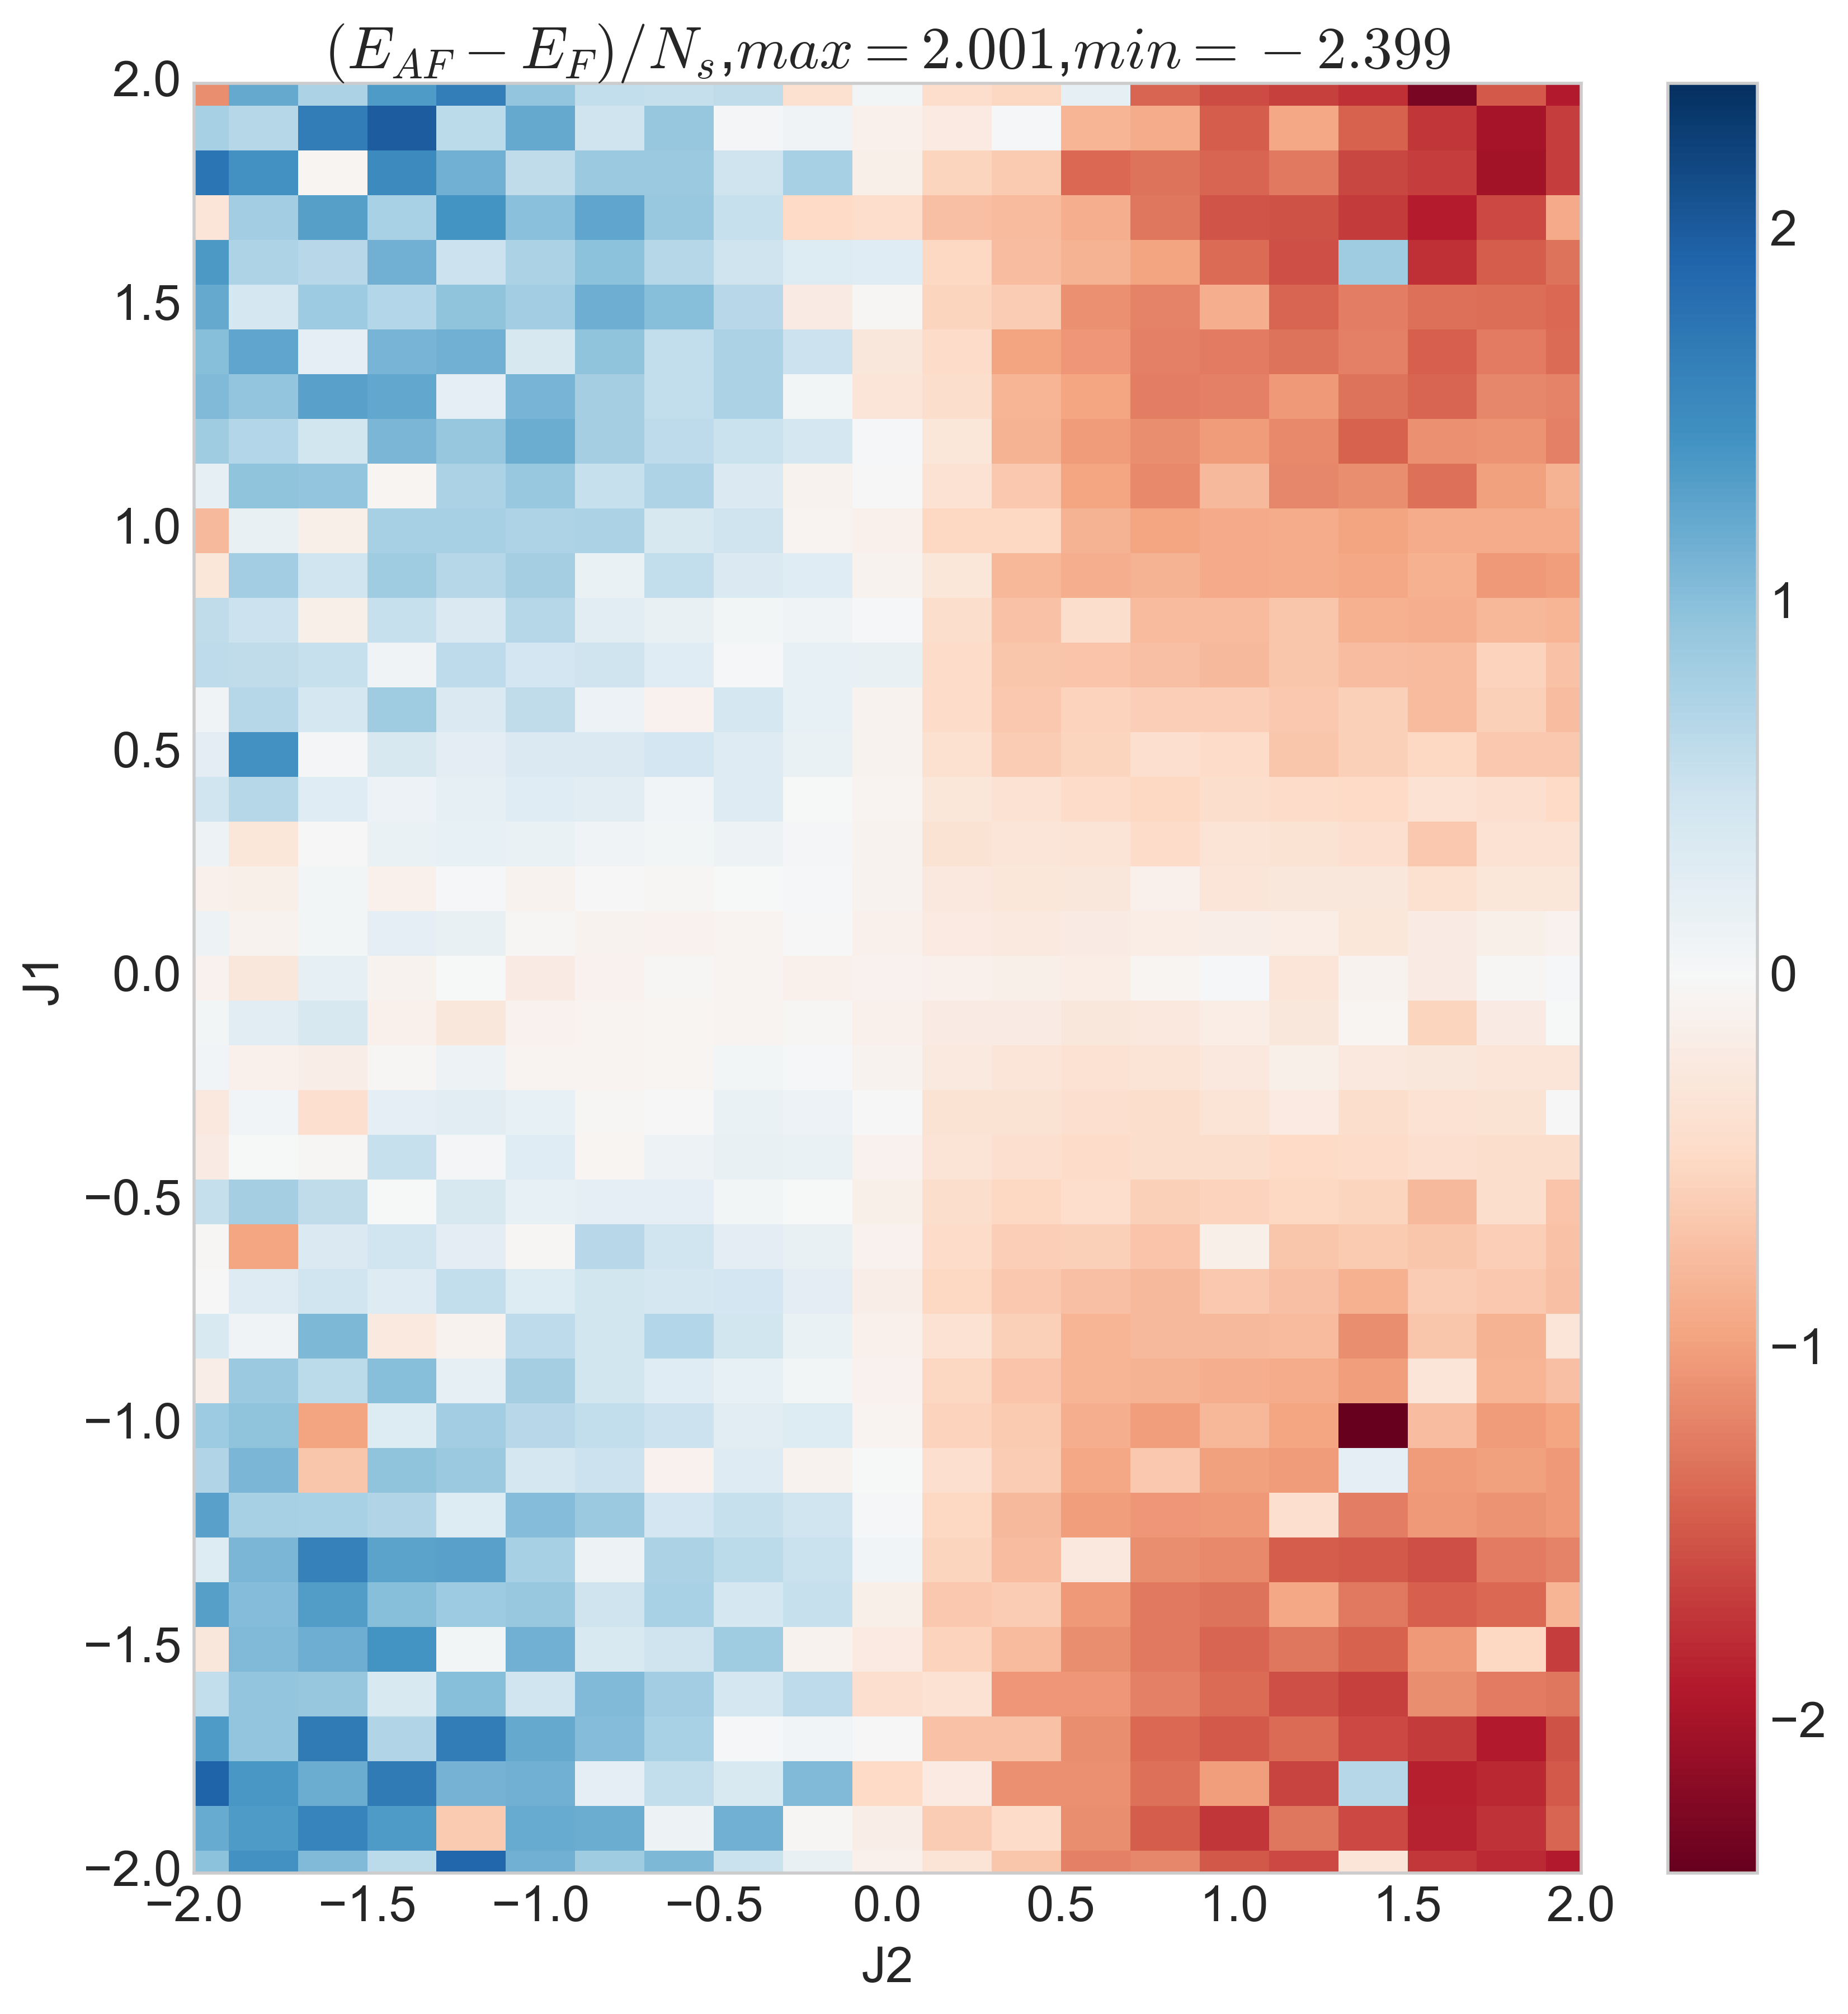

In [100]:
x, y = np.array(df_pivoted.index), np.array(df_pivoted.columns)
z = np.array(df_pivoted)
print(len(x), len(y),len(z))
print(z.shape)

iterator = 0

#z=z.reshape(len(x), len(y))
z_min, z_max = np.min(z), np.max(z)
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_xlim(np.min(y), np.max(y))
ax.set_ylim(np.min(x), np.max(x))
ax.set_xlabel('J2')
ax.set_ylabel('J1')
ax.set_title('$(E_{AF} - E_{F})/N_s$,'+f'$max={z_max:.3f}$,$min={z_min:.3f}$')
ax.tick_params(labelrotation=0)
c = ax.pcolormesh(y,x,z, cmap='RdBu', vmin=z_min, vmax=abs(z_min))
#c = ax.imshow(z)
#ax.set_xlim([np.min(x),np.max(x)])
#ax.set_ylim([np.min(y),np.max(y)])
fig.colorbar(c, ax=ax)
plt.show()

# EXTRACT

In [13]:
Lx = 5
Ly = 5
Ns = Lx * Ly
d = 2
bc = 1

Jdd = -1.0
cos_theta_af = None
cos_theta_f = None

if d == 1:
    cos_theta_af = np.array([1 if i % 2 == 0 else -1 for i in range(Lx)])
    cos_theta_f = np.ones(Lx)
else:
    cos_theta_af = []
    if Lx % 2 == 0:
        for j in range(Ly):
            for i in range(Lx):
                n = j * Lx + i
                cos_theta_af.append((1 if i % 2 == 0 else -1) if j % 2 == 0 else (-1 if i % 2 == 0 else 1))
        cos_theta_af = np.array(cos_theta_af)
    else:            
        cos_theta_af = np.array([1 if i%2==0 else -1 for i in range(Ns)])
    cos_theta_f = np.ones(Ns)

print(cos_theta_af)

en_ferro = Jdd * np.sum(cos_theta_f[0:-1] * cos_theta_f[1:])
en_aferro = Jdd * np.sum(cos_theta_af[0:-1] * cos_theta_af[1:])

en_ferro, en_aferro

[ 1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1
  1]


(-24.0, 24.0)

In [20]:
dir = lambda lx, ly, bc, d, typ : f"./resultsClassicalNew/{typ},Lx={lx},Ly={ly},bc={bc},d={d}/"
d = dir(Lx, Ly, bc, d, 'aferro')
d

'./resultsClassicalNew/aferro,Lx=5,Ly=5,bc=1,d=2/'

In [54]:
dir_inner = lambda dir, n_vis, lr, J, Jz, Jdd :f"{dir}n_visible={n_vis},n_hidden={(2*n_vis)},batch=1024,lr={lr}/__hei_dots,dN={n_vis},Ns={n_vis},J={J:.2f},Jx=0.00,Jy=0.00,Jz={Jz:.2f},d=1.00,J0=0.00,Jdd={Jdd:.2f}/"

dd = dir_inner(d, Ns, 0.01, 1.00, 0.00, -1.00)
dd

'./resultsClassicalNew/aferro,Lx=5,Ly=5,bc=1,d=2/n_visible=25,n_hidden=50,batch=1024,lr=0.01/__hei_dots,dN=25,Ns=25,J=1.00,Jx=0.00,Jy=0.00,Jz=0.00,d=1.00,J0=0.00,Jdd=-1.00/'

(<AxesSubplot:>,
 energy   -24.758607
 dtype: float64)

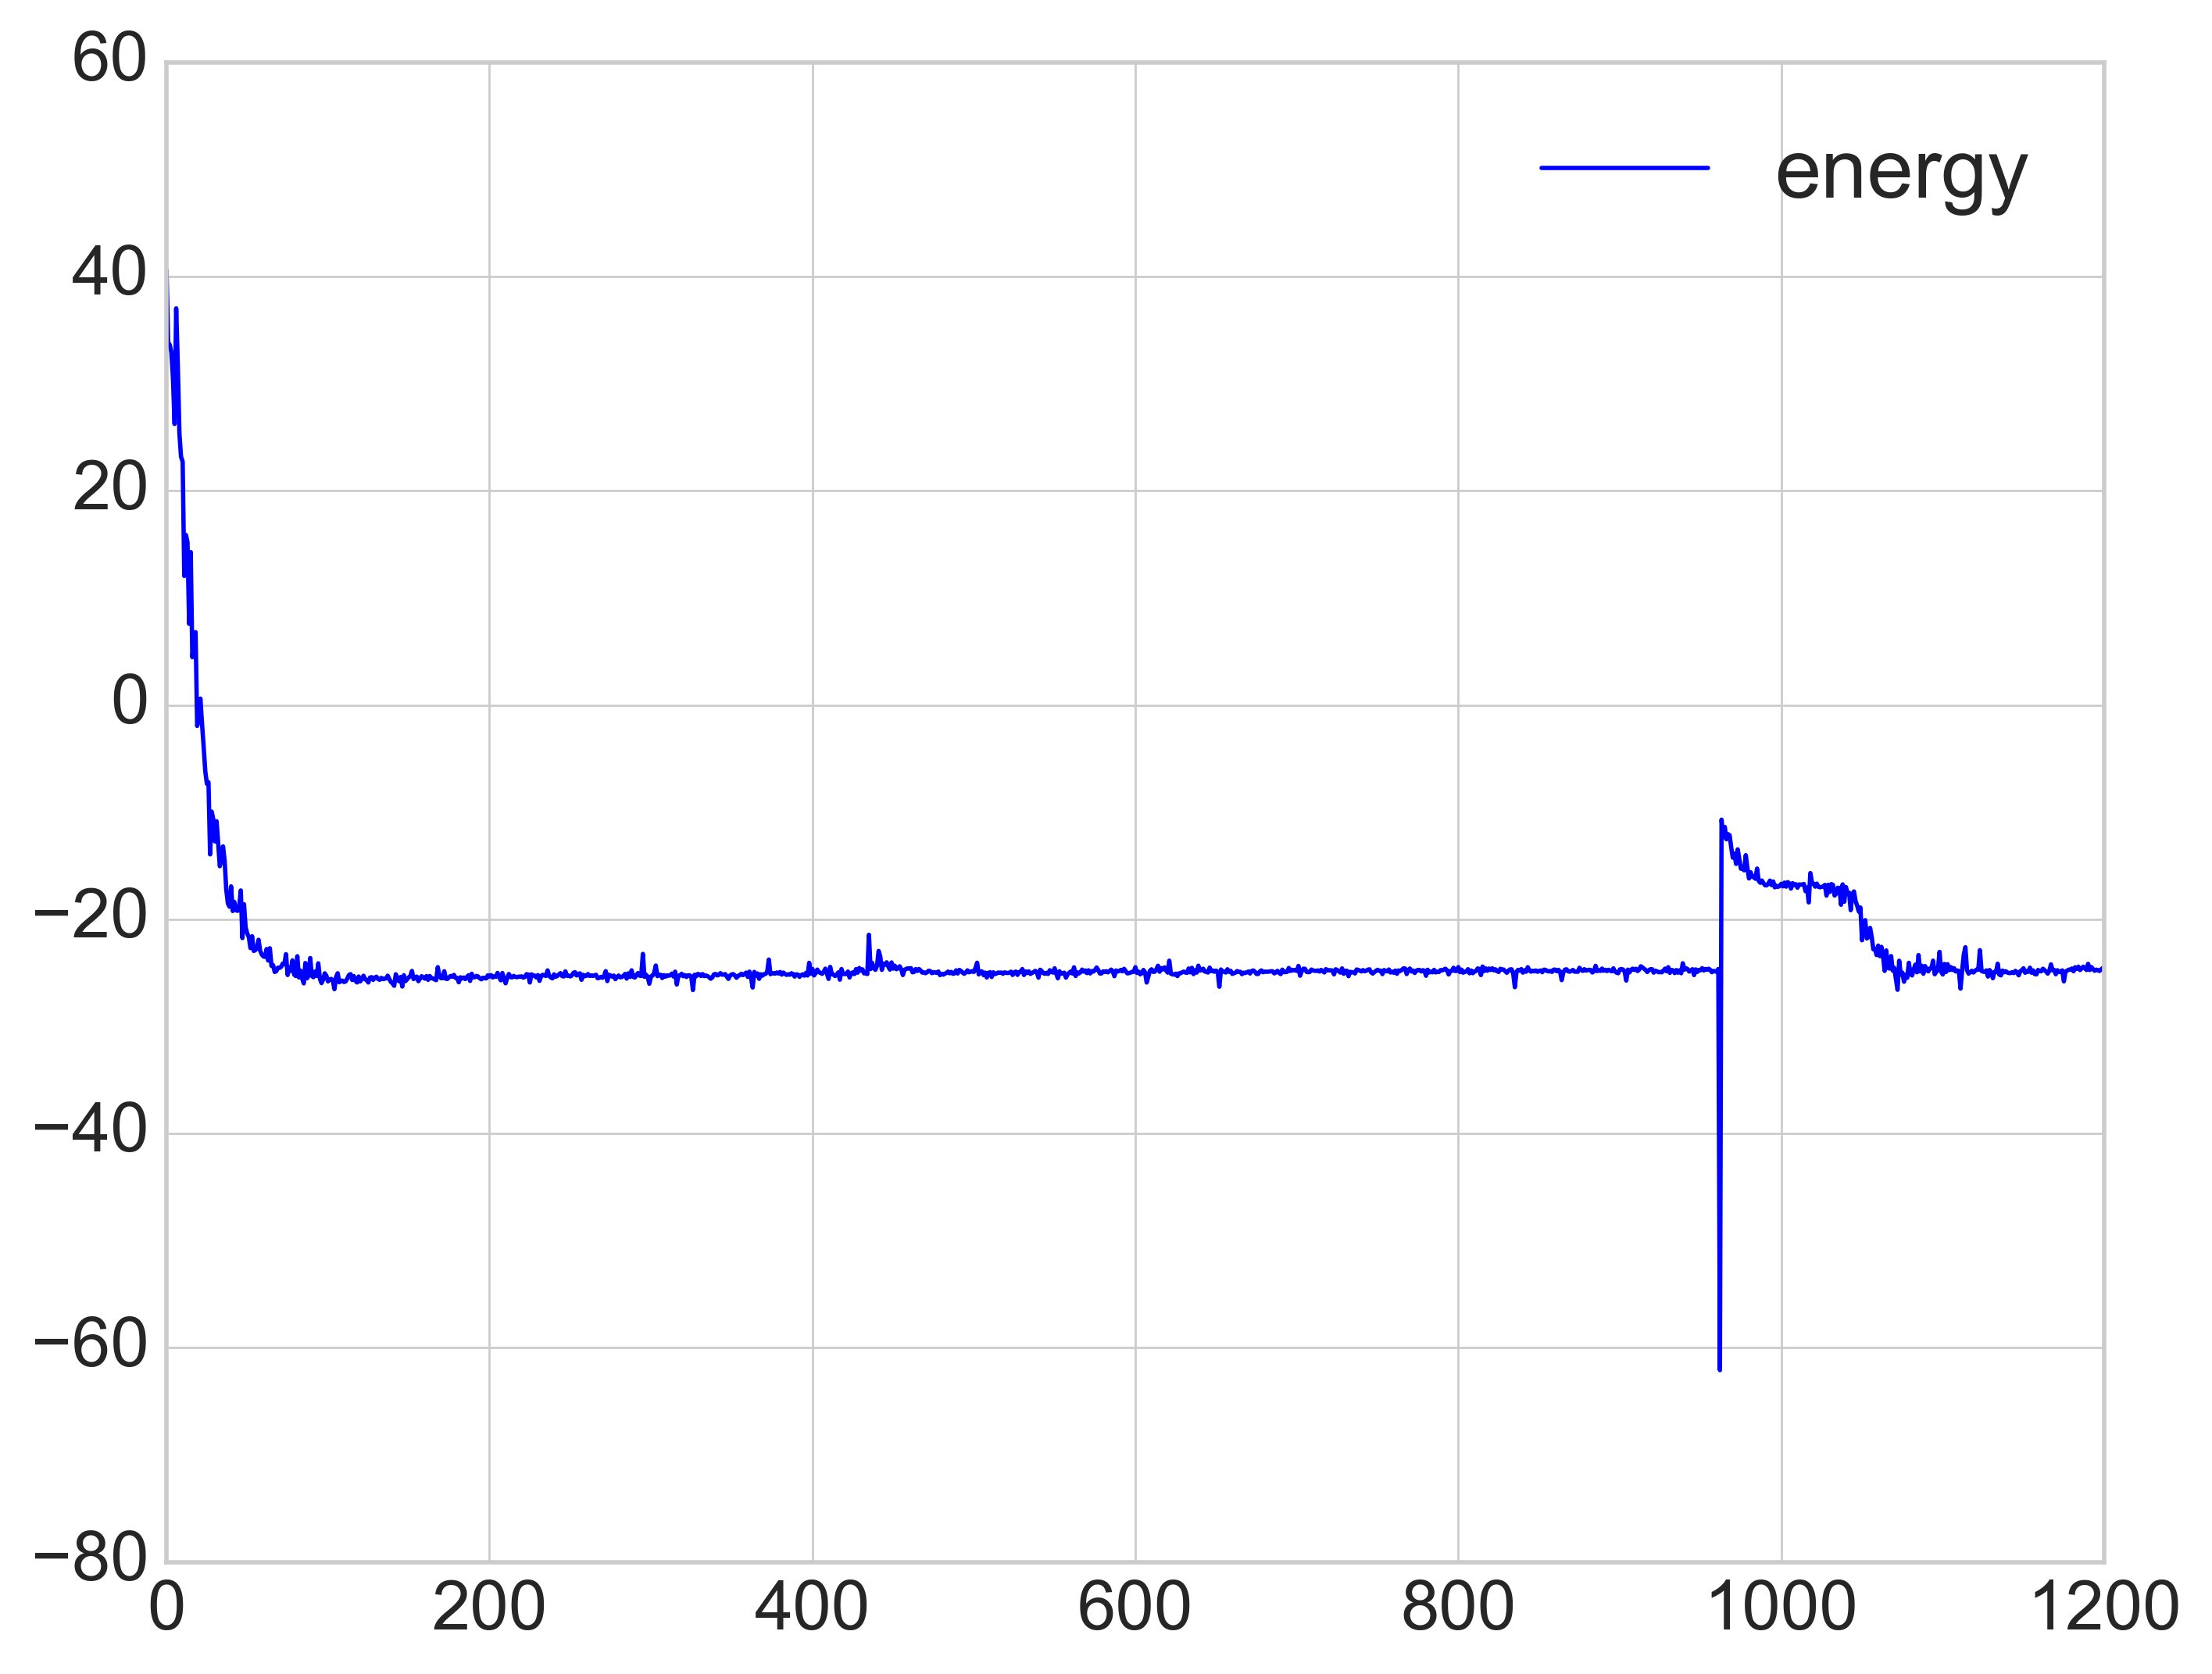

In [58]:
os.listdir(dd)
df = pd.read_csv(dir_inner(d, Ns, 0.01, 1.00, -1.00, -1.00)+'energies.dat', sep = '\t', index_col=0, names=['energy','s']).drop(columns=['s'])

df.plot(), df.tail(100).mean()

In [ ]:
energies = np.zeros((40,40))
for J in enumerate(np.arange(-2.0, 2.0, 0.1)):
    for Jz in enumerate(np.arange(-2.0, 2.0, 0.1)):
        

# OTHERS

In [5]:
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_x = np.array([[0,1],[1,0]])
sigma_z = np.array([[1, 0],[0, -1]])
ones = np.eye(2)
sigma_y, sigma_x, sigma_z, ones

(array([[ 0.+0.j, -0.-1.j],
        [ 0.+1.j,  0.+0.j]]),
 array([[0, 1],
        [1, 0]]),
 array([[ 1,  0],
        [ 0, -1]]),
 array([[1., 0.],
        [0., 1.]]))

In [6]:
sigma_y_1 = np.kron(sigma_y, ones)
sigma_x_1 = np.kron(sigma_x, ones)
sigma_z_1 = np.kron(sigma_z, ones)
sigma_y_1, sigma_x_1

(array([[0.+0.j, 0.+0.j, 0.-1.j, 0.-0.j],
        [0.+0.j, 0.+0.j, 0.-0.j, 0.-1.j],
        [0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j]]),
 array([[0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.]]))

In [7]:
sigma_y_0 = np.kron(ones, sigma_y)
sigma_x_0 = np.kron(ones, sigma_x)
sigma_z_0 = np.kron(ones, sigma_z)
sigma_y_0, sigma_x_0, sigma_z_0

(array([[0.+0.j, 0.-1.j, 0.+0.j, 0.-0.j],
        [0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.-0.j, 0.+0.j, 0.-1.j],
        [0.+0.j, 0.+0.j, 0.+1.j, 0.+0.j]]),
 array([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]]),
 array([[ 1.,  0.,  0.,  0.],
        [ 0., -1.,  0., -0.],
        [ 0.,  0.,  1.,  0.],
        [ 0., -0.,  0., -1.]]))

In [8]:
#|00>=|1000>
# flips
state = np.array([1,0,0,0])
flip0 = sigma_x_0.dot(state)
spin0 = sigma_z_0.dot(state)
print(flip0, spin0)
flip1 = sigma_x_1.dot(state)
spin1 = sigma_z_1.dot(state)
print(flip1, spin1)


s0 = -1
s1 = -1
state_changed = sigma_y_1.dot(state)
sigma_y_0.dot(state_changed)

[0. 1. 0. 0.] [1. 0. 0. 0.]
[0. 0. 1. 0.] [1. 0. 0. 0.]


array([ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j])

In [9]:
#|00>=|0100>
# flips
state = np.array([0,1,0,0])
flip0 = sigma_x_0.dot(state)
spin0 = sigma_z_0.dot(state)
print(flip0, spin0)
flip1 = sigma_x_1.dot(state)
spin1 = sigma_z_1.dot(state)
print(flip1, spin1)


s0 = -1
s1 = -1
state_changed = sigma_y_1.dot(state)
sigma_y_0.dot(state_changed)

[1. 0. 0. 0.] [ 0. -1.  0.  0.]
[0. 0. 0. 1.] [0. 1. 0. 0.]


array([0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j])

In [10]:
#|01>=|0010>
# flips
state = np.array([0,0,1,0])
flip0 = sigma_x_0.dot(state)
spin0 = sigma_z_0.dot(state)
print(flip0, spin0)
flip1 = sigma_x_1.dot(state)
spin1 = sigma_z_1.dot(state)
print(flip1, spin1)


s0 = -1
s1 = -1
state_changed = sigma_y_1.dot(state)
sigma_y_0.dot(state_changed)

[0. 0. 0. 1.] [0. 0. 1. 0.]
[1. 0. 0. 0.] [ 0.  0. -1.  0.]


array([0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j])

In [11]:
#|11>=|0001>
# flips
state = np.array([0,0,0,1])
flip0 = sigma_x_0.dot(state)
spin0 = sigma_z_0.dot(state)
print(flip0, spin0)
flip1 = sigma_x_1.dot(state)
spin1 = sigma_z_1.dot(state)
print(flip1, spin1)


s0 = -1
s1 = -1
state_changed = sigma_y_1.dot(state)
sigma_y_0.dot(state_changed)

[0. 0. 1. 0.] [ 0.  0.  0. -1.]
[0. 1. 0. 0.] [ 0.  0.  0. -1.]


array([-1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j])

In [12]:
sigma_x_1*sigma_x_0 - sigma_x_0*sigma_x_1

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [13]:
sigma_y_1*sigma_y_0 - sigma_y_0*sigma_y_1

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [14]:
sigma_z_1*sigma_z_0 - sigma_z_0*sigma_z_1

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])